<a href="https://colab.research.google.com/github/xysu129/deep-learning-ust-2026/blob/main/HW3_plateaus_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

# 1. Data Preparation

In [3]:
# The MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# FCN, Flattened input: 784 vectors
X_train_flat = X_train_full.reshape(60000, 784).astype('float32') / 255
X_test_flat = X_test.reshape(10000, 784).astype('float32') / 255

# CNN, 2D Image input: 28x28x1
X_train_cnn = X_train_full.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test_cnn = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255

# One-hot encode labels
Y_train_full = to_categorical(y_train_full, 10)
Y_test = to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 2. Model Definitions

In [4]:
def build_fcn():
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn():
    model = Sequential()
    # Conv Block 1
    model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    # Conv Block 2
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Conv Block 3
    model.add(Conv2D(64,(3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    # Conv Block 4
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# 3. Experiment Loop

In [5]:
# define different subset sizes to simulate "Size of training data"
data_sizes = [100, 500, 1000, 2000, 5000, 10000, 20000, 40000, 60000]
results_list = []

fcn_accuracies = []
cnn_accuracies = []

for size in data_sizes:
    print(f"Training models on {size} samples...")

    # Select a random subset of training data
    indices = np.random.choice(len(X_train_full), size, replace=False)

    # Train FCN
    fcn = build_fcn()
    # Train for a fixed number of epochs to see convergence capability
    fcn.fit(X_train_flat[indices], Y_train_full[indices],
            batch_size=128, epochs=10, verbose=0)
    score_fcn = fcn.evaluate(X_test_flat, Y_test, verbose=0)
    fcn_accuracies.append(score_fcn[1]) # Append accuracy

    # Train CNN
    cnn = build_cnn()
    cnn.fit(X_train_cnn[indices], Y_train_full[indices],
            batch_size=128, epochs=10, verbose=0)
    score_cnn = cnn.evaluate(X_test_cnn, Y_test, verbose=0)
    cnn_accuracies.append(score_cnn[1])

    results_list.append([size, score_fcn[1], score_cnn[1]])

Training models on 100 samples...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training models on 500 samples...
Training models on 1000 samples...
Training models on 2000 samples...
Training models on 5000 samples...
Training models on 10000 samples...
Training models on 20000 samples...
Training models on 40000 samples...
Training models on 60000 samples...


In [6]:
df = pd.DataFrame(results_list, columns=["Training Samples", "FCN Accuracy", "CNN Accuracy"])
df["FCN Gain"] = df["FCN Accuracy"].diff()
df["CNN Gain"] = df["CNN Accuracy"].diff()

print("\nExperiment Results:")
print(df)


Experiment Results:
   Training Samples  FCN Accuracy  CNN Accuracy  FCN Gain  CNN Gain
0               100        0.7154        0.1972       NaN       NaN
1               500        0.8756        0.1135    0.1602   -0.0837
2              1000        0.9042        0.1135    0.0286    0.0000
3              2000        0.9257        0.1135    0.0215    0.0000
4              5000        0.9502        0.4668    0.0245    0.3533
5             10000        0.9649        0.9855    0.0147    0.5187
6             20000        0.9725        0.9875    0.0076    0.0020
7             40000        0.9794        0.9919    0.0069    0.0044
8             60000        0.9799        0.9910    0.0005   -0.0009


# 4. Visualization

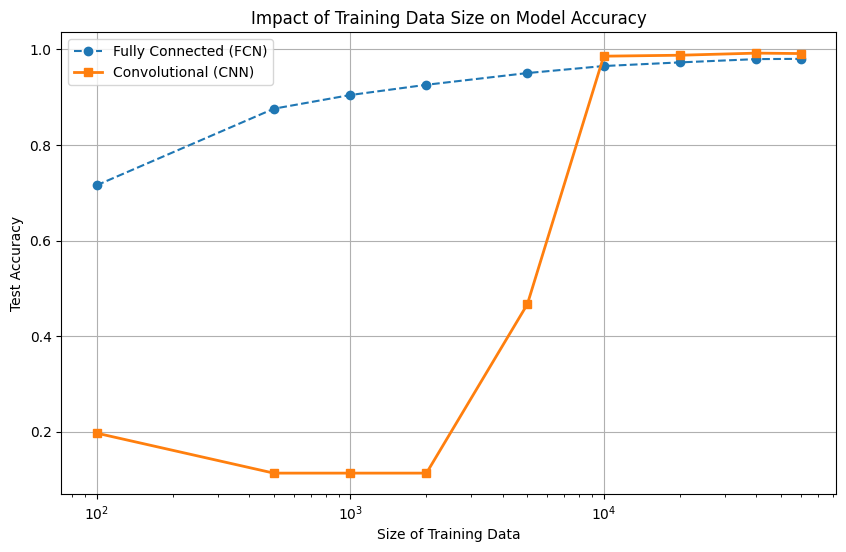

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, fcn_accuracies, marker='o', label='Fully Connected (FCN)', linestyle='--')
plt.plot(data_sizes, cnn_accuracies, marker='s', label='Convolutional (CNN)', linewidth=2)

plt.xscale('log')

plt.title('Impact of Training Data Size on Model Accuracy')
plt.xlabel('Size of Training Data')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 5. Conclusion

- The Fully Connected Network (FCN) plateaus first.
- The data table shows that once the training sample size reaches a certain magnitude (e.g., 10,000 to 20,000), the accuracy gain of the FCN becomes negligible (e.g., less than 0.005), indicating model saturation.
- In contrast, the CNN continues to show performance improvements with larger datasets, demonstrating a higher capacity for feature extraction and a higher learning limit.